1. Difficulty evaluation using trajectory rewards

Visualization of the state

In [10]:
% load_ext autoreload
% autoreload 2

from copy import copy

import matplotlib
import torch
from IPython.core.display import clear_output
from torch.nn import LeakyReLU

from framework import TrajectoryRewardsEvaluator, QEvaluator, DQNAgent
from pendulum import PendulumEnvironment, PendulumRenderer, PendulumState
from pendulum.heuristic import *
from shared_parameters import *
from utils import mean, running_average
from utils import save, load, set_matplotlib_colors

set_matplotlib_colors(matplotlib, text_color="black", label_color="white")
import matplotlib.pyplot as plt

torch.set_printoptions(sci_mode=False)

UsageError: Line magic function `%` not found.


In [ ]:
env = PendulumEnvironment(*pendulum_env_args, time_scale=5, step_reward=1.0, action_reward=-0.1, death_reward=-100.0)
renderer = PendulumRenderer(bob_radius, connector_length, enemy_radius, enemy_y)

renderer.render(env.get_starting_state(), to_image=True)


### Note for all difficulty estimators

Currently, we have a small embedding space (just one dimension),
thus it's possible to pre-evaluate it directly, and then use the
cached difficulty evaluations.

Within the bigger space it's not possible, and we will have to
come up with some clever way of caching, where we don't store the
evaluation for every point space, but neither perform an evaluation
each time for each point.

### Direct difficulty estimation

In [8]:
oracle = HeuristicPendulumEvaluator(connector_length, max_angle, enemy_radius, bob_radius)
state = env.get_starting_state()
difficulty = oracle(state)

print(state.to_string())
print(f"difficulty: {difficulty.item():.3f}")

Pendulum(angle: 0.63, angular_speed: 0.05, vertical_position: 0.00, enemies: -0.06)
difficulty: 0.653


### Difficulty estimation using trajectory rewards

In [9]:
skills = [1.0, 0.5, 0.0]
weights = [0.5, 0.25, 0.25]
agents = [HeuristicPendulumActor(enemy_radius, bob_radius, connector_length, enemy_y, skill=skill) for skill in skills]
oracle = TrajectoryRewardsEvaluator(env, agents, weights, num_evaluations=10, max_trajectory_length=20)

states = torch.vstack([env.get_starting_state() for _ in range(10)])
oracle.evaluate(states)

tensor([0.2954, 0.0762, 0.7320, 0.9072, 0.6382, 0.8839, 0.1979, 0.8172, 0.7571,
        0.8782])

### Difficulty estimation using Q-values

1. Train agents, save at time steps
2. Use them in QEvaluator

In [10]:
# Try to load saved agents
agents = load("./saved_data/saved_agents.pt", none_on_error=True)
print(f"Loaded: {agents}")

agent = DQNAgent(PendulumState.get_size(1), action_size=2, hidden=[8, 8], activation=LeakyReLU())
if agents is None:
    agents = []
else:
    # Load the latest agent
    for p1, pt1, p2, pt2 in zip(agents[-1].nn.parameters(), agents[-1].target_nn.parameters(),
                                agent.nn.parameters(), agent.target_nn.parameters()):
        p2.data = p1.data
        pt2.data = pt1.data

total_rewards = []

Loaded: [<framework.agents.dqn_agent.DQNAgent object at 0x000001CFAB8AC550>, <framework.agents.dqn_agent.DQNAgent object at 0x000001CFAB8A80A0>, <framework.agents.dqn_agent.DQNAgent object at 0x000001CFAB8A8490>, <framework.agents.dqn_agent.DQNAgent object at 0x000001CFAB8A8790>]


Run next cell to train the agent until you're satisfied. Run the cell above it to save the agent

loss: 90.6985855102539. Mean total reward: -2.816200000000006


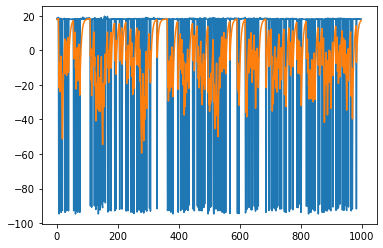

In [232]:
# Train the agent for N iterations
agent.eval = False
loss = agent.train(env, epochs=100, max_trajectory_length=20)
agent.eval = True

for _ in range(10):
    state = env.get_starting_state()
    total_reward = 0.0

    for _ in range(20):
        action = agent.get_action(state)
        state, reward, done = env.transition(state, action)
        total_reward += reward
        if done:
            break

    total_rewards.append(total_reward)
    if len(total_rewards) > 1000:
        total_rewards.pop(0)

clear_output(wait=True)
print(f"loss: {loss}. Mean total reward: {mean(total_rewards)}")
plt.plot(total_rewards)
plt.plot(running_average(total_rewards))
plt.show()

In [233]:
# Use this to append an agent
agents.append(copy(agent))
print(f"Total of: {len(agents)} agents")
save(agents, "./saved_data/saved_agents.pt")

Total of: 4 agents


Now we have our agents, let's run the evaluator

In [11]:
for agent in agents:
    agent.eval = True

weights = [0.1, 0.2, 0.3, 0.4]
oracle = QEvaluator(env, agents, weights, num_evaluations=1, max_trajectory_length=20)
oracle(env.get_starting_state())

tensor(0.3774)

### Evaluators comparison

In [17]:
# Heuristic evaluator
oracle_h = HeuristicPendulumEvaluator(connector_length, max_angle, enemy_radius, bob_radius)

# Trajectory rewards evaluator
skills = [1.0, 0.5, 0.0]
weights = [0.5, 0.25, 0.25]
agents = [HeuristicPendulumActor(enemy_radius, bob_radius, connector_length, enemy_y, skill=skill) for skill in skills]
oracle_r = TrajectoryRewardsEvaluator(env, agents, weights, num_evaluations=10, max_trajectory_length=20)

# Q-Evaluator
agents = load("./saved_data/saved_agents.pt")
for agent in agents:
    agent.eval = True

weights = [0.1, 0.2, 0.3, 0.4]
oracle_q = QEvaluator(env, agents, weights, num_evaluations=1, max_trajectory_length=20)

print("Difficulty evaluation of the same random state:")

state = env.get_starting_state()
print(f"State: {state}")
print()

print(f"Heuristic: {oracle_h(state).item():.4f}")
print(f"Trajectory Rewards: {oracle_r(state).item():.4f}")
print(f"Q-Evaluator: {oracle_q(state).item():.4f}")

print()
print("Difficulty of several states:")

states = torch.vstack([env.get_starting_state() for _ in range(5)])
print(f"H: {oracle_h(states)}")
print(f"R: {oracle_r(states)}")
print(f"Q: {oracle_q(states)}")

print()
print("Difficulty of the whole range")

states = []
evaluations_h = []
evaluations_r = []
evaluations_q = []
state = env.get_starting_state()
num_states = 26
for i, x in enumerate(torch.linspace(enemy_x_min, enemy_x_max, num_states)):
    print(f"Evaluating {i + 1}/{num_states}")
    s = state.clone()
    s.enemy_x = x
    states.append(x)

    evaluations_h.append(oracle_h(s))
    evaluations_r.append(oracle_r(s))
    evaluations_q.append(oracle_q(s))

Difficulty evaluation of the same random state:
State: tensor([ 0.4957,  0.0500,  0.0000, -0.0051])

Heuristic: 0.6527
rewards
tensor([[[-90.0000, -90.0000, -90.0000, -90.0000, -90.0000, -90.0000, -90.0000,
          -90.0000, -90.0000, -90.0000],
         [-91.2000, -91.2000,  19.4000, -91.3000, -90.0000, -89.4000, -91.2000,
          -89.2000, -91.3000, -91.1000],
         [-91.7000, -91.5000, -89.6000, -89.7000, -91.4000, -91.4000, -88.7000,
          -90.5000, -89.6000, -91.5000]]])

max: 19.399999618530273. min: -91.69999694824219

Difficulties
tensor([[[0.9847, 0.9847, 0.9847, 0.9847, 0.9847, 0.9847, 0.9847, 0.9847,
          0.9847, 0.9847],
         [0.9955, 0.9955, 0.0000, 0.9964, 0.9847, 0.9793, 0.9955, 0.9775,
          0.9964, 0.9946],
         [1.0000, 0.9982, 0.9811, 0.9820, 0.9973, 0.9973, 0.9730, 0.9892,
          0.9811, 0.9982]]])

Difficulties max: 1.0 min: 0.0
Trajectory Rewards: 0.9627
Q-Evaluator: 0.0400

Difficulty of several states:
H: tensor([0.6031, 0.3931, 0.

PendulumState(
  angle: 0.64,
  angular_speed: -0.05,
  vertical_position: 0.00,
  enemies: -0.25
)


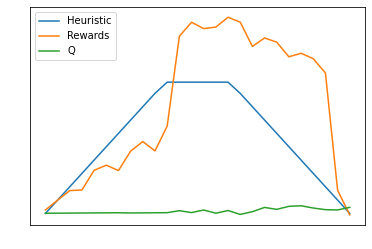

In [21]:
print(state.to_string())
plt.plot(states, evaluations_h)
plt.plot(states, evaluations_r)
plt.plot(states, evaluations_q)
plt.legend(["Heuristic", "Rewards", "Q"])
plt.show()